In [1]:
import gensim
word2vec_path = "/ilab/users/kc1026/Documents/cs543/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [2]:
score_tr = []
score_ts = []

In [3]:
import numpy as np
import pandas as pd 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

stop_words = set(stopwords.words('english'))
EMBEDDING_DIM = 300 
MAX_VOCAB_SIZE = 175303
MAX_SEQUENCE_LENGTH = 150 

/usr/lib/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
df = pd.read_csv("/ilab/users/kc1026/Documents/cs543/emoji.csv", sep=',', header=0)
train, test = train_test_split(df, test_size=0.1)
df.count()

text     7480
label    7480
dtype: int64

In [5]:
train['label'][4]

4

In [6]:
tokenizer = RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: re.sub("[^a-zA-Z']", ' ', x))
test['text'] = test['text'].apply(lambda x: re.sub("[^a-zA-Z']", ' ', x))

/usr/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# all_training_words = [word for token in train["token"] for word in token]
# training_sentence_lengths = [len(token) for token in train["token"]]
# TRAINING_VOCAB = sorted(list(set(all_training_words)))
# print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
# print("Max sentence length is %s" % max(training_sentence_lengths))


In [8]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(train["text"].tolist())
x_training_sequences = tokenizer.texts_to_sequences(train["text"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

# set max length of sequences, now all data has the same length of 300
train_rnn_data = pad_sequences(x_training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

num_words = len(train_word_index) + 1
train_embedding_weights = np.zeros((num_words, EMBEDDING_DIM))
for word,index in train_word_index.items():
    if word in word2vec:
        train_embedding_weights[index,:] = word2vec[word]     


Found 8538 unique tokens.


In [9]:
test_sequences = tokenizer.texts_to_sequences(test["text"].tolist())
test_rnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = test_rnn_data
y_test = np_utils.to_categorical(test['label'].values)

In [10]:
x_train = train_rnn_data
y_train = np_utils.to_categorical(train['label'].values)

In [11]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Model
batch_size = 128 
num_epochs = 6 


model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[train_embedding_weights], input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(7,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop',metrics = ['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          2561700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 2,722,807
Trainable params: 2,722,807
Non-trainable params: 0
_________________________________________________________________


In [13]:
import time
start = time.time()
model.fit(x_train, y_train, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
end = time.time()

Train on 6058 samples, validate on 674 samples
Epoch 1/6
6058/6058 [==============================] - 16s 3ms/step - loss: 1.7858 - acc: 0.3098 - val_loss: 1.5763 - val_acc: 0.4451
Epoch 2/6
6058/6058 [==============================] - 13s 2ms/step - loss: 1.4166 - acc: 0.4987 - val_loss: 1.3925 - val_acc: 0.5089
Epoch 3/6
6058/6058 [==============================] - 12s 2ms/step - loss: 1.1728 - acc: 0.5910 - val_loss: 1.2718 - val_acc: 0.5445
Epoch 4/6
6058/6058 [==============================] - 11s 2ms/step - loss: 1.0190 - acc: 0.6477 - val_loss: 1.2065 - val_acc: 0.5935
Epoch 5/6
6058/6058 [==============================] - 12s 2ms/step - loss: 0.8804 - acc: 0.7007 - val_loss: 1.1585 - val_acc: 0.6068
Epoch 6/6
6058/6058 [==============================] - 11s 2ms/step - loss: 0.7820 - acc: 0.7392 - val_loss: 1.1880 - val_acc: 0.6024


In [154]:
score_tr.append(model.evaluate(x_train, y_train, verbose=0))
score_ts.append(model.evaluate(x_test, y_test, verbose=0))

In [25]:
score_tr

[1.6211808926281444, 0.558823529252394]

In [156]:
score_ts

[[1.354431872061867, 0.5213903746502923],
 [1.244536823129909, 0.546791443531526],
 [1.2175572619718664, 0.5681818178630768],
 [1.1609265208244324, 0.6082887697347346],
 [1.4552140427145728, 0.5935828880192762]]

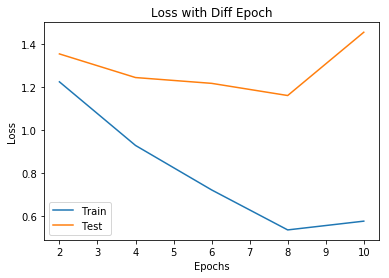

In [157]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt



plt.plot([2, 4, 6, 8, 10], np.array(score_tr)[:,0], label="Train")
plt.plot([2, 4, 6, 8, 10], np.array(score_ts)[:,0], label="Test")

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title("Loss with Diff Epoch")
plt.legend()

plt.show()

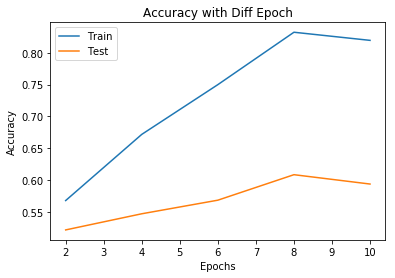

In [158]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt



plt.plot([2, 4, 6, 8, 10], np.array(score_tr)[:,1], label="Train")
plt.plot([2, 4, 6, 8, 10], np.array(score_ts)[:,1], label="Test")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title("Accuracy with Diff Epoch")
plt.legend()

plt.show()
